### These are helper functions that get used later on but should be compiled first. 

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

def get_scores(y_pred):
    my_scores = []
    
    mse_values = ["MSE"]
    mse = mean_squared_error(y_test, y_pred)
    mse_dummy = mean_squared_error(y_test, y_pred_dummy)
    
    mse_values.append(mse)
    mse_values.append(mse_dummy)

    my_scores.append(mse_values)



    r2_values = ["R2"]
    r2 = r2_score(y_test, y_pred)
    r2_dummy = r2_score(y_test, y_pred_dummy)

    r2_values.append(r2)
    r2_values.append(r2_dummy)

    my_scores.append(r2_values)



    mae_values = ["MAE"]
    mae = mean_absolute_error(y_test, y_pred)
    mae_dummy = mean_absolute_error(y_test, y_pred_dummy)

    mae_values.append(mae)
    mae_values.append(mae_dummy)

    my_scores.append(mae_values)


    print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

    for item in my_scores:
        ratio = item[1]/item[2] if item[2] != 0 else 0
        print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
        
        # print the ratio of the mse score over the mean value of y_test
    print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")
    

# UC3M-MLBD (GitHub Repo Name)

**Authors**: João M. Carvalho (100521356), George Y. Fang (100521298)

Repo for UC3M's ML for Business Decision Making course

**NIA number**: 56

## Project 1: Predicting Solar Energy Production with scikit-learn

### Introduction
This assignment focuses on practicing machine learning methods and hyper-parameter tuning to determine the optimal model for a given dataset. Participants will engage in model selection, evaluation, and making predictions on unseen data.

The context of this assignment is the challenge of forecasting energy production from renewable sources, specifically wind and solar energy. Unlike traditional sources, the generation of solar and wind energy depends on weather conditions and must be accurately predicted 24 hours in advance to ensure a balanced electricity network. Accurate weather forecasting models, like GFS and ECMWF, play a crucial role in predicting variables related to these renewable energies.

We will use meteorological data forecasted by GFS to train a machine learning model that estimates solar energy production at a solar plant in Oklahoma. The available dataset contains 15 meteorological variables, each forecasted at 5 different times of the day and at 4 locations around the solar plant, leading to 300 input attributes in total. The dataset spans from 1994-2007, and the model’s performance will be evaluated using competition data from 2008-2009. The objective is to accurately predict the energy produced, with the last column of the dataset indicating the response variable, i.e., the energy production.

### Deliverables
* EDA
* Two Simple models (KNN and DecisionTreeRegressor) and training and evaluation process description
* At Least Two Advanced models (SVM, RandomForest, GradientBoosting) and training and evaluation process description
* One Final Model (Using Joblib) and training and evaluation process description
* One .csv file with final predictions

# Part 0: Importing the data

We start by importing the data with our NIA number which is 56. In order to do this, we need to import the libraries we will use.

In [30]:
import pandas as pd
import numpy as np

Now we can read the provided .pkl file with pandas and create a dataframe with the data. We will also look at df.head to make sure that everything was imported correctly.

In [31]:
ava = pd.read_pickle('data/ava_st1_ns4_56.pkl')
ava.head
comp = pd.read_pickle('data/comp_st1_ns4_56.pkl')
comp.head

<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V4381    0.000000         0.0          1    0.000000    0.000000  269.677721   
V4382    0.000000         0.0          1    0.000000    0.000000  267.930467   
V4383    0.000000         0.0          1    0.000000    0.000000  262.911266   
V4384    0.000000         0.0          1    0.000000    0.000000  287.294791   
V4385    0.000000         0.0          1    0.000000    0.000000  281.137748   
...           ...         ...        ...         ...         ...         ...   
V5109    0.000000         0.0          1    0.001818    0.010000  220.382263   
V5110    0.046364         0.0          1    0.000000    0.000000  246.255685   
V5111    0.000000         0.0          1    0.000000    0.001818  220.178289   
V5112    0.000000         0.0          1    0.000000    0.000000  218.933680   
V5113    0.000000         0.0          1    0.000000    0.000000  240.577497   

       dl

#### Check for Missing Values

In [32]:
missing_values_count = max(ava.isnull().sum())
print(f"Number of missing values: {missing_values_count}")

Number of missing values: 0


#### Identify and Drop Constant Columns

In [33]:
# Shows all columns with only 1 unique value
constant_columns = [col for col in ava.columns if ava[col].nunique() < 2]
print(f"The Constant Columns Are: {constant_columns}")
print(f"Number of constant columns: {len(constant_columns)}")

# Drop the constant columns
print(f"Number of columns before dropping constant columns: {len(ava.columns)}")
ava.drop(labels=constant_columns, axis=1, inplace=True)
comp.drop(labels=constant_columns, axis=1, inplace=True)
print(f"Number of columns after dropping constant columns: {len(ava.columns)}")



The Constant Columns Are: ['apcp_sf3_1', 'apcp_sf1_2', 'apcp_sf2_2', 'uswrf_s1_2']
Number of constant columns: 4
Number of columns before dropping constant columns: 301
Number of columns after dropping constant columns: 297


#### Detect Categorical Columns

In [34]:
#Check for categorical columns
categorical_columns = ava.select_dtypes(include=['category']).columns
print(f"The Categorical Columns Are: {categorical_columns}")
print(f"Number of categorical columns: {len(categorical_columns)}")


The Categorical Columns Are: Index(['dswrf_s4_1', 'tmax_2m5_1', 'ulwrf_t4_1', 'uswrf_s3_1', 'uswrf_s4_1',
       'pwat_ea4_2', 'tmp_sfc5_2', 'ulwrf_s5_2', 'pres_ms2_3', 'pwat_ea4_3',
       'tcdc_ea2_3', 'tcolc_e1_3', 'tcolc_e5_3', 'tmp_sfc3_3', 'dswrf_s5_4',
       'tmin_2m4_4', 'tmp_2m_4_4'],
      dtype='object')
Number of categorical columns: 17


#### Visualization

After that initial cleanup, we can start looking at some visual representations of the data which will help us understand it better. We will start by looking at the histogram of the data to understand the distribution of energy values.

In [35]:
# First import the libraries we need
import matplotlib.pyplot as plt

# Now separate the data into X and y.
x = ava.drop('energy', axis=1)
y = ava['energy']

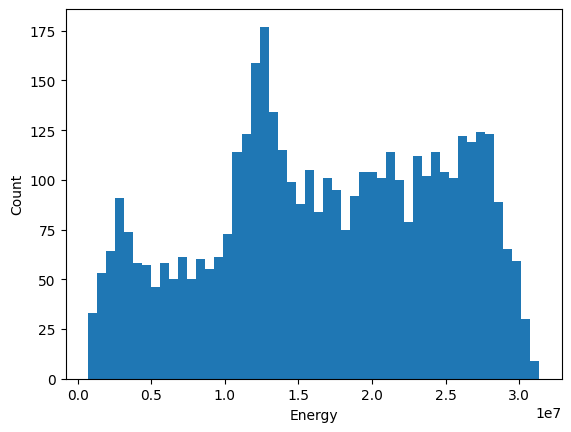

In [36]:
# To actually plot the histogram, we use matplotlib.pyplot.hist()
plt.hist(y, bins=50)
plt.xlabel('Energy')
plt.ylabel('Count')
plt.show()

As we can see in the histogram, our data appears to bi-modal. This will impact which evaluation model we use because we will need to make sure that error measurements are not skewed by the bi-modal distribution. 

Even though the distribution appears not to have any outliers, we will use the IQR method to detect and confirm this.

In [37]:
q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5*iqr)
upper_bound = q3 + (1.5*iqr)

# Identify the number of outliers

print('number of outliers: ', len(y[y > upper_bound]) + len(y[y < lower_bound]))

number of outliers:  0


With no outliers detected, we can proceed with the creation of our models. 

## EDA Summary

Constant Columns: There are four constant column ['apcp_sf3_1', 'apcp_sf1_2', 'apcp_sf2_2', 'uswrf_s1_2']. These columns will be dropped from the dataset as they are redundant and would not contribute to the model accuracy. 

Missing Values: There are no missing values.

Categorical Variables: There are 17 categorical columns detected. This will be an issue for models like KNN and SVM because these algorithms are typically designed to work with numerical data. KNN relies on a distance metric to find the "nearest neighbors" in the feature space. Common distance metrics include Euclidean distance. For numerical features, distance calculations are straightforward. However, when dealing with categorical features, defining meaningful distances becomes more complex. SVMs often use the "kernel trick" to implicitly map data into a higher-dimensional space. This is more straightforward with numerical features. We will implement one-hot encoding to convert categorical features into numerical features.

## 1st Model: KNN 

Our 1st model is a K Nearest Neighbors model. This model is a non-parametric method used for classification and regression. It is a lazy learning algorithm that stores all instances corresponding to training data in n-dimensional space. When an unknown discrete data is received, it analyzes the closest k number of instances saved (nearest neighbors) and returns the most common class as the prediction and for real-valued data, it returns the mean of k nearest neighbors. 

We will start by splitting the data into training and testing sets. We will use 80% of the data for training and 20% for testing. We will also use the random_state parameter (NIA:56) to ensure that the data is split in the same way every time we run the code. This will allow us to compare the results of different models more easily.

Import the dependencies we'll need for the model.

In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

#### Standardize and scale the data for this kind of model

Given that we have some categorical data, we will need to use one-hot encoding to convert the categorical features into numerical features. This step is necessary because KNN relies on a distance metric to find the "nearest neighbors" in the feature space. Common distance metrics include Euclidean distance. For numerical features, distance calculations are straightforward. However, when dealing with categorical features, defining meaningful distances becomes more complex.


In [39]:
preprocessor = ColumnTransformer(
    transformers = [
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64)),
        ('OHE', OneHotEncoder(drop='first'), make_column_selector(dtype_include='category'))
    ],
    remainder = 'passthrough'
)

preprocessor.fit(x)

X = preprocessor.transform(x)




To dive deeper into our preprocessor, heres was each step does:

Standardization for Float64 Features (STscaler):

- StandardScaler is applied to features with data type float64. Standardization scales the features so that they have a mean of 0 and a standard deviation of 1. This is important for models that rely on distance metrics, such as K-Nearest Neighbors (KNN) and Support Vector Machines (SVM). Standardizing features ensures that each feature contributes equally to the distance computations.

Min-Max Scaling for Int64 Features (MMscaler):

- MinMaxScaler is applied to features with data type int64. Min-Max scaling transforms the features to a specific range (usually between 0 and 1). This is particularly useful for algorithms like SVMs, Neural Networks, and models that utilize gradient descent, as it prevents features with larger magnitudes from dominating the learning process.

One-Hot Encoding for Categorical Features (OHE):

- OneHotEncoder is applied to features with data type categorical. One-hot encoding transforms categorical features into numerical features. This is important because many machine learning algorithms cannot operate on categorical data directly. Instead, they require numerical features to perform computations. One-hot encoding is a common technique for converting categorical features into numerical features.

Passthrough for Remaining Features (remainder='passthrough'):

- The remainder parameter is set to 'passthrough', meaning that any features not explicitly transformed by the specified scalers will be kept in their original form. This is important to ensure that categorical features or those that don't require scaling are not modified.

## Now we can create the basic model without any hyperparameter tuning and see how it performs.

First let's split the data into training and testing sets. This will be the same split we use for the rest of the models. This holdout method is a simple way to evaluate a model by splitting the data into training and testing sets. The model is trained on the training set and then evaluated on the testing set. However, it has some drawbacks. For example, the model is only trained on a subset of the data, which can lead to overfitting. Additionally, the model is only evaluated on a subset of the data, which can lead to high variance in the evaluation metrics. We'll use cross-validation later to address these issues.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)


#### Import the model from sci-kit lean and we'll fit the data and predict the output.

In [41]:
from sklearn.neighbors import KNeighborsRegressor

# Instantiate the model, leaving default values for all hyperparameters which is n= 5
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

# We'll now make our predictions
y_pred = knn.predict(X_test)

We'll make a DummyRegressor model to compare the results of our KNN model to a trivial model that just predicts the mean of the training data.

In [42]:
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

### Now for metrics

First we import the dependencies we'll need for the metrics.

In [43]:

# Use that helper function from the top of the file to get scores
get_scores(y_pred)



Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       12981489825913.064   61839876045693.438   0.210     
R2                        0.790                -0.003               -287.241  
MAE                       2416365.430          6744592.742          0.358     
Ratio of mae over mean value of y: 0.143


#### Residuals

We'll take a look at a plot of the residuals of the model predictions to see if there are any trends or patterns that the model is missing.

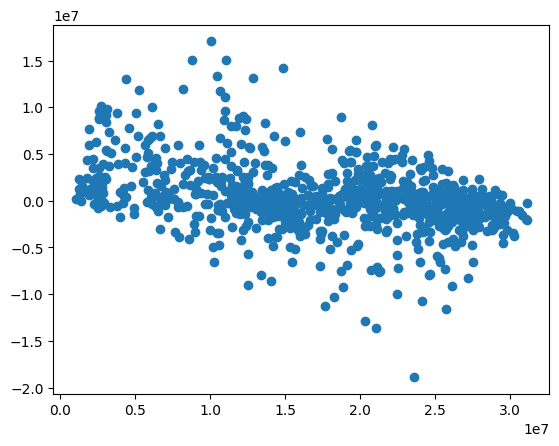

In [44]:
plt.scatter(y_test, y_pred - y_test)
plt.show()

We can see that the residuals are mostly homoscedastic, but there is a slight decreasing trend. This is likely due to the bi-modal distribution of the data and is leading to some over-prediction of the lower values and under-prediction of the higher values. Next we'll tune the hyperparameters of the model to see if we can improve the performance.

## Hyperparameter Tuning using k-fold Cross-Validation

In [45]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

# Define the cross validation scheme. We will use KFold with 5 folds and no shuffling because the data is ordered.
cv = KFold(n_splits=5, shuffle=False)


scores = cross_val_score(knn, X, y, cv=cv, scoring='neg_mean_absolute_error')
print(scores)
print(f"{'Average MAE scores without HPO: '}", -scores.mean())
print(f"{'Average MAE scores without HPO as a percentage of the mean y value: '}", f"{(-scores.mean()/np.mean(y)*100):.2f}", '%')


# Define the search space

param_grid = {
    'n_neighbors': list(range(1, 50)),
}

# Define the grid search
better_knn = GridSearchCV(knn, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_error')



[-2531520.27671233 -2591816.2739726  -2204672.21643836 -2475971.28493151
 -2570046.20821918]
Average MAE scores without HPO:  2474805.252054794
Average MAE scores without HPO as a percentage of the mean y value:  14.67 %


#### Validating with MSE, R2, and MAE

Validating a machine learning model using multiple evaluation metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²), gives us a comprehensive understanding of the model's performance from different perspectives. Each metric shows different aspects of the model's predictive ability and suitability for specific applications. Here's why it's important to consider these metrics:

#### *Mean Squared Error (MSE):*
**Role:**

- MSE measures the average squared difference between the predicted and actual values.
  
**Importance:**
- Sensitivity to Outliers: MSE is sensitive to outliers due to the squaring of errors. It penalizes large errors more than smaller errors, making it effective in scenarios where large errors are critical.
- Optimization Objective: Many machine learning algorithms, especially regression models, are trained by minimizing MSE. Minimizing MSE during training often leads to models that perform well in terms of overall error.

#### *Mean Absolute Error (MAE):*
**Role:**
- MAE measures the average absolute difference between the predicted and actual values.
  
**Importance:**
- Robustness to Outliers: MAE is less sensitive to outliers than MSE since it doesn't involve squaring errors. It provides a more robust measure of the average error.
- Interpretability: MAE is easy to interpret, representing the average magnitude of errors. This makes it useful for understanding the typical prediction error.

#### *R-squared (R²):*

**Role:** 
- R² quantifies the proportion of the variance in the dependent variable that is predictable from the independent variables.

**Importance:**
- Model Fit: R² indicates how well the model's predictions match the variability in the actual data. A higher R² suggests a better fit.
- Comparisons: R² provides a standardized metric for model comparison. It ranges from 0 to 1, where 1 indicates a perfect fit. It's especially useful when comparing models with different scales of the dependent variable.

#### Primary Metric

Due to the bi-modal distribution of the data, we will use MAE as our primary metric for evaluating the model. MAE is less sensitive to large errors than MSE since it doesn't involve squaring errors. It provides a more robust measure of the average error when you consider the two peaks or "normal area" in the distribution. 


In [46]:

# Fit grid search
better_knn.fit(X_train, y_train) 
better_scores = cross_val_score(better_knn, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

print(f"{'Scores from CV with HPO'}", better_scores)
print(f"{'Average MAE scores with HPO: '}", -better_scores.mean())
print(f"{'Average MAE scores with HPO as a percentage of the mean y value: '}", f"{(-better_scores.mean()/np.mean(y)*100):.2f}", '%')

best_n = better_knn.best_params_['n_neighbors']

print(f"{'The best number of neighbors when using negative mean absolute error scoring is: '}", best_n)
print(f"{'The best MAE score attained was: '}", -better_knn.best_score_)

print(f"{'HPO leads to a '}", f"{(1-(-better_scores.mean()/np.mean(y))/(-scores.mean()/np.mean(y)))*100:.2f}", '%', " improvement in MAE score over the model without HPO")

Scores from CV with HPO [-2261770.89586305 -2335000.17689016 -2288003.35261315 -2373923.14934709
 -2453240.01285714]
Average MAE scores with HPO:  2342387.517514118
Average MAE scores with HPO as a percentage of the mean y value:  13.88 %
The best number of neighbors when using negative mean absolute error scoring is:  14
The best MAE score attained was:  2330471.897291682
HPO leads to a  5.35 %  improvement in MAE score over the model without HPO


That was a lot, but what happened was, we used the GridSearchCV function to test different values for the hyperparameters of the model. Going from 1 to 50 neighbors and using the mean squared error as the scoring metric. We used 5-fold cross-validation to evaluate the performance of each model. This means that the data was split into 5 subsets, and each model was trained on 4 of the subsets and evaluated on the remaining subset. This process was repeated 5 times, so that each subset was used as the evaluation set once. The final score for each model was the average of the 5 evaluation scores. This is a more robust method of evaluating a model than the holdout method because it uses all of the data for training and evaluation. It also reduces the variance in the evaluation metrics because each model is evaluated on all of the data.

With this, we found that the ideal number of neighbors is 14, and this results in a mean absolute error of 2342387.517514118, which is just 13.88% of the mean energy production. This is a significant improvement over the dummy model, which had a mean absolute error of  61839876045693.438, and the non-tuned model, which had a mean absolute error of 2474805.252054794, which is 14.67% of the mean energy production.

### Now that we found the best n-neighbors, we can create a new model with that parameter and see how it performs.

In [47]:
# Instantiate the model with the best known parameters
final_knn = KNeighborsRegressor(n_neighbors=best_n)
final_knn.fit(X_train, y_train)
final_y_pred = final_knn.predict(X_test)
get_scores(final_y_pred)

Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       12182122728685.301   61839876045693.438   0.197     
R2                        0.802                -0.003               -291.957  
MAE                       2393483.813          6744592.742          0.355     
Ratio of mae over mean value of y: 0.142


## Summary of KNN Model

First, we created a KNN model without HPO, and subsequently used GridSearchCrossValidation to find the best hyperparameters for the model. Creating a new model with this parameter, we were able to reduce the mean absolute error from 2474805.252054794 to 2393483.813, which is 14.2% of the mean energy production. 

That said, the final R2 score was 0.802, and the MAE ratio once the new model was trained with all of the X_train data, was 14.2% of the mean energy production. 

# 2nd Model Decision Tree Regressor Model

Our second model is the DecisionTreeRegressor. A Decision Tree Regressor is used for predicting continuous values. It works by recursively partitioning the data into subsets based on the values of input features, ultimately providing a tree-like structure of decisions. 

#### How it Works
First, you must split the data. The algorithm starts at the root node and selects the feature that best splits the data into subsets. The "best" split is determined by reducing the variance of the target variable within each subset. Next is recursive partitioning. This process is repeated for each subset, creating child nodes. This recursive partitioning continues until a stopping criterion is met, such as reaching a maximum depth or having a minimum number of samples in a node. The final nodes, called leaf nodes, contain the predicted continuous value. This value is often the mean or median of the target variable within that leaf.

#### Key Features
Interpretability:
- Decision trees are easy to interpret and visualize. The resulting tree structure can be understood and analyzed, making it a valuable tool for decision-making.

Non-linear Relationships:
- Decision trees can capture non-linear relationships between features and the target variable. They are capable of fitting complex patterns in the data.

Robust to Outliers:
- Decision trees are less sensitive to outliers compared to some other regression models. They partition the data based on relative ordering rather than absolute values.

### Preprocessing

As explained before, preprocessing is an important step in the machine learning pipeline as it helps enhance the performance and reliability of the models. Here, the ColumnTransformer is utilized to apply specific preprocessing techniques to different types of features, addressing their unique characteristics. Specifically, we are standardizing the data and scaling it for easier processing. For DecisionTreeRegressor, preprocessing is less important because it is inherently robust to the scale of features. 

In [48]:
preprocessor = ColumnTransformer(
    transformers = [
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64))
    ],
    remainder = 'passthrough'
)

preprocessor.fit(x)

X =  preprocessor.transform(x)



Importing the Decision Tree Regressor model from sklearn

In [49]:
from sklearn.tree import DecisionTreeRegressor

Now we create the DecisionTreeRegressor model, fit it to the training data and make a prediction on the test data that will be validated in subsequent cells. We'll also evaluate this model using the same metrics as the KNN model.

In [50]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

get_scores(y_pred)


Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       21307687735816.109   61839876045693.438   0.345     
R2                        0.654                -0.003               -238.120  
MAE                       3090907.370          6744592.742          0.458     
Ratio of mae over mean value of y: 0.183


## Here's a plot of the residuals of the decision tree model predictions to see if there are any trends or patterns that the model is missing.

plt.scatter(y_test, y_pred - y_test)
plt.show()

# K-Fold Cross Validation

As we learned in class, while classification trees use measures like entropy or Gini impurity to evaluate the quality of a split, regression trees use variance (or equivalently, mean squared error) as the criterion for splitting. The key idea is to minimize the variance within each node. When constructing a decision tree for regression, at each step, the algorithm considers all possible splits on all features and selects the split that minimizes the variance of the target variable within each resulting node.

In [51]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

# Define the cross validation scheme.
cv = KFold(n_splits=5, shuffle=True, random_state=56)


scores = cross_val_score(tree, X, y, cv=cv, scoring='neg_mean_absolute_error')
print(scores)
print(f"{'Average MAE scores without HPO: '}", -scores.mean())
print(f"{'Average MAE scores without HPO as a percentage of the mean y value: '}", f"{(-scores.mean()/np.mean(y)*100):.2f}", '%')

[-3054806.52054795 -3099557.76712329 -2865166.84931507 -2939665.65753425
 -3293205.78082192]
Average MAE scores without HPO:  3050480.515068493
Average MAE scores without HPO as a percentage of the mean y value:  18.08 %


param_grid defines the hyperparameter space that we want to search over to find the best combination of hyperparameters for our decision tree model, specifically these parameters:
'max_depth': Specifies the maximum depth of the decision tree. 
'min_samples_split': Specifies the minimum number of samples required to split an internal node. 
'max_features': Specifies the maximum number of features considered for splitting a node. It includes different options like using all features (None), the square root of the total features ('sqrt'), and the base-2 logarithm of the total features ('log2')

better_tree is a GridSearchCV object that performs a grid search over the specified hyperparameter space.

In [52]:
# Define the search space

param_grid = {
    'max_depth': [1,2,3,4,5,6,7,8,9,11,13,15],
    'min_samples_split': [2, 5, 10, 20], 
    'max_features': [None, 'sqrt', 'log2']
}

better_tree = GridSearchCV(tree, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_error', refit=True)


better_tree.fit(X_train, y_train) 
better_scores = cross_val_score(better_tree, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

print(f"{'Scores from CV with HPO'}", better_scores)
print(f"{'Average MAE scores with HPO: '}", -better_scores.mean())
print(f"{'Average MAE scores with HPO as a percentage of the mean y value: '}", f"{(-better_scores.mean()/np.mean(y)*100):.2f}", '%')

Scores from CV with HPO [-2717472.00044766 -2619285.74697302 -2346688.25993026 -2463276.24921119
 -2571012.26017026]
Average MAE scores with HPO:  2543546.9033464775
Average MAE scores with HPO as a percentage of the mean y value:  15.08 %


In [53]:
print(f"{'The best parameters when using negative mean absolute error scoring is: '}", better_tree.best_params_)
print(f"{'The best MAE score attained was: '}", -better_tree.best_score_)

print(f"{'HPO leads to a '}", f"{(1-(-better_scores.mean()/np.mean(y))/(-scores.mean()/np.mean(y)))*100:.2f}", '%', " improvement in MAE score over the model without HPO")


The best parameters when using negative mean absolute error scoring is:  {'max_depth': 5, 'max_features': None, 'min_samples_split': 10}
The best MAE score attained was:  2501714.9112142795
HPO leads to a  16.62 %  improvement in MAE score over the model without HPO


### Now let's use this new model to predict values of the test data and evaluate the model.

In [54]:
better_predictions = better_tree.predict(X_test)

get_scores(better_predictions)

Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       13496110953313.287   61839876045693.438   0.218     
R2                        0.781                -0.003               -284.205  
MAE                       2533680.845          6744592.742          0.376     
Ratio of mae over mean value of y: 0.150


#### Summary of Results

From the results we can see the r2 value of _________ and the mean absolute error of _________. This is a significant improvement from the baseline model which had an r2 value of _________ and a mean absolute error of _________. Compared to KNN, the model performes ___(better/worse)__ in terms of r2 and mean absolute error.

# 3rd Model: Random Forest Regressor

### Now we're getting to some more advanced models. 

The next model we will use is the Random Forest Regressor. A Random Forest Regressor is an ensemble learning method that combines multiple decision trees to create a "forest" of trees. Since we've already handled the data processing and splitting, we can jump right into creating the model.

#### Creating the model

In [55]:
# Import necessary dependencies
from sklearn.ensemble import RandomForestRegressor

# instantiate the model with default hyperparameters
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

### With the DummyRegressor model already created, we can compare the results of our Random Forest Regressor model to a trivial model that just predicts the mean of the training data. 

In [56]:
get_scores(y_pred)

Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       9989405311625.869    61839876045693.438   0.162     
R2                        0.838                -0.003               -304.893  
MAE                       2130625.881          6744592.742          0.316     
Ratio of mae over mean value of y: 0.126


#### Now we'll look at the residuals again

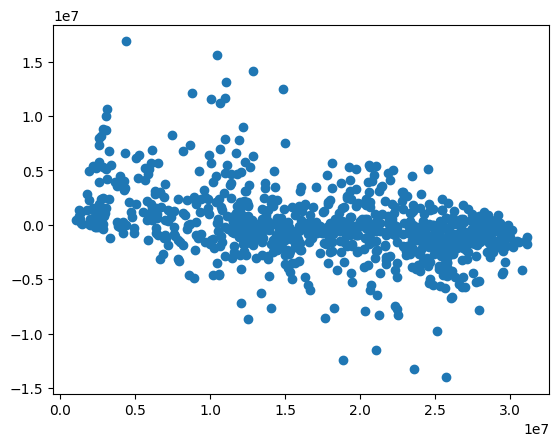

In [57]:
plt.scatter(y_test, y_pred - y_test)
plt.show()

The majority of points are centered around 0, but there are some outliers that are causing the model to over-predict the lower values and under-predict the higher values. We'll tune the hyperparameters of the model to see if we can improve the performance. However, this plot is better than some of the others we've looked at because the residuals are mostly homoscedastic.

# K-Fold Cross Validation

Now we'll use k-fold cross-validation to tune the hyperparameters of the model. We'll use parameters of this model that we found most important from the scikit-learn docs.

In [58]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 100)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 50)]
min_samples_split = [2, 3, 4, 5, 6, 7, 10, 13, 14, 15, 18, 20]
min_samples_leaf = [1, 2, 3, 4, 6, 8]




param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf    
    
}




rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = 3, verbose=2, random_state=56, n_jobs = -1, scoring='neg_mean_absolute_error')


rf_random.fit(X_train, y_train) 



print(f"{'The best parameters are: '}", rf_random.best_params_)

best_n_estimators = rf_random.best_params_['n_estimators']
best_min_samples_split = rf_random.best_params_['min_samples_split']
best_min_samples_leaf = rf_random.best_params_['min_samples_leaf']
best_max_features = rf_random.best_params_['max_features']
best_max_depth = rf_random.best_params_['max_depth']
random_state = 56

print(f"{'The best MAE score attained was: '}", -rf_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


The best parameters are:  {'n_estimators': 710, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 67}
The best MAE score attained was:  2122806.9102860675


#### Looking at RandomizedSearchCV

Here we randomly take some number of combinations of the param_grid and find the best combination for our model. This is a more efficient method than GridSearchCV because it doesn't try every single combination of hyperparameters. Instead, it randomly samples a subset of the combinations and evaluates them. It saves us time because there are fewer combinations to evaluate, but it also means that we might not find the best combination of hyperparameters. 

As far as the function goes, we're testing 100 different iterations of the parameters, but we fit them 3 times using cross validation. The n_jobs parameter is set to -1 so that the search uses all available processors. This speeds up the search because it can evaluate multiple combinations of hyperparameters simultaneously. Especially since we trained this model on a machine with a AMD Ryzen 9 7950X 16-core CPU, it allows us to take advantage of all 32 local processors.

#### I wanted to check if there was a pattern I could see in any one of the hyperparameters, so I plotted them all. I'll plot the n_estimators here to show that there is no correlation and the rest had very similar results.

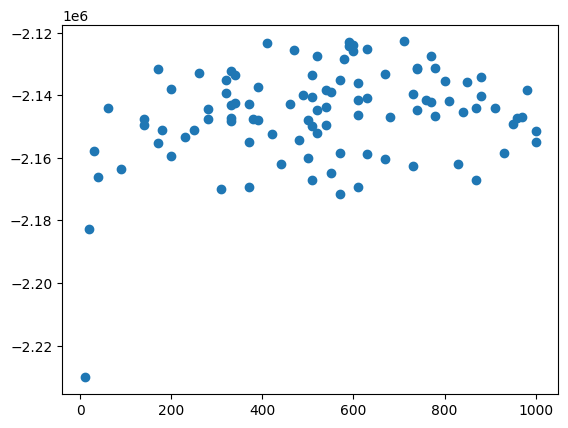

In [60]:
new_frame = pd.DataFrame(rf_random.cv_results_)[['mean_test_score', 'std_test_score', 'params']].sort_values(by='mean_test_score', ascending=False)

# make a plot with the mean test score on the y axis and n_estimators on the x axis, repeat for other parameters
plt.scatter(new_frame['params'].apply(lambda x: x['n_estimators']),new_frame['mean_test_score'])
plt.show()

#### Now we can create a new model with the best hyperparameters and see how it performs.

In [61]:
final_rf = RandomForestRegressor(n_estimators=best_n_estimators, min_samples_split=best_min_samples_split, min_samples_leaf=best_min_samples_leaf, max_features=best_max_features, max_depth=best_max_depth, random_state=random_state) # 2125951.299093535

final_rf.fit(X_train, y_train)
rf_pred = final_rf.predict(X_test)

get_scores(rf_pred)

Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       9629812328136.816    61839876045693.438   0.156     
R2                        0.844                -0.003               -307.014  
MAE                       2088768.111          6744592.742          0.310     
Ratio of mae over mean value of y: 0.124


Let's take a look at residuals to see if there's any improvement.

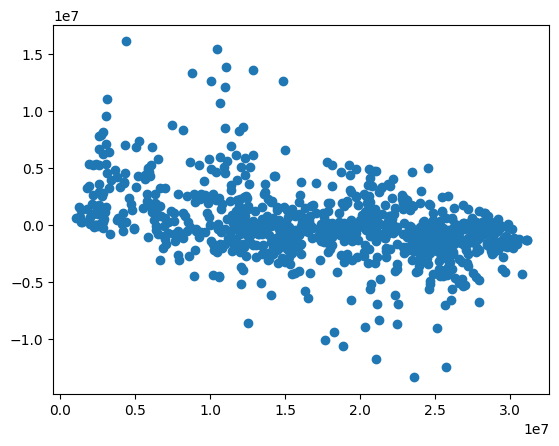

In [62]:
plt.scatter(y_test, rf_pred - y_test)
plt.show()

As we can see, the plot has slightly converged more towards 0, decreasing our residuals and improving our model's scores.

# 4th Model: SVM (Scalable Vector Machine) Model

The Scalable Vector Machine model can be used for both classification and regression tasks. It is particularly effective in high-dimensional spaces and is well-suited for cases where the data is not linearly separable. SVMs work by finding the optimal hyperplane that best separates different classes or predicts a continuous target variable. In a binary classification task, the SVM seeks to find the optimal hyperplane that maximally separates two classes. The hyperplane is a decision boundary in the feature space. For a two-dimensional space, the hyperplane is a line. In higher dimensions, it becomes a hyperplane. Support vectors are data points that are closest to the decision boundary (hyperplane). These points are critical in determining the position and orientation of the hyperplane. The margin is the distance between the hyperplane and the nearest data point from each class. SVM aims to maximize this margin, making the decision boundary robust to new data points.

For regression tasks, SVM aims to fit a hyperplane that captures the trend of the data while allowing a certain deviation. SVR introduces a tube around the regression line, and the goal is to fit the line within this tube, allowing for a certain deviation (controlled by the hyperparameter epsilon). SVR minimizes the loss function, which penalizes points that fall outside the tube.

Advantages:
- Effective in High Dimensions: SVM performs well even in high-dimensional spaces.
- Robust to Overfitting: By maximizing the margin, SVM tends to be less prone to overfitting.
- Versatile: Can handle both linear and non-linear relationships in data.

Limitations:
- Computational Complexity: Training an SVM can be computationally expensive, especially for large datasets.

This model is a little different from the other models in that we use a pipeline to preprocess the data. In order to do this, we have to split the data first, and then create the pipeline. 

In [63]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=56)


#### Creating the pipeline

Previously I was using the ColumnTransformer to create a preprocessing pipeline to apply different scaling techniques to the columns. However,  I switched to using the Pipeline class to create a pipeline that applies the preprocessing steps and the model. This is because the ColumnTransformer does not allow for the use of the GridSearchCV, RandomSearchCV, or BayesSearchCV class to tune the hyperparameters of the model.

In [64]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

# This is the preprocessing pipeline: SVMs need scaling and one-hot encoder
preprocessor = ColumnTransformer(
    transformers=[
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64)),
        ('OHE', OneHotEncoder(drop='first'), make_column_selector(dtype_include='category'))
    ],
    remainder='passthrough'
)
# We use gausian / radial kernel
svr = SVR(kernel="rbf")

# Combining the preprocessor with the SVM classifier in a pipeline
pipe_scale_svr = Pipeline([
    ('preprocessor', preprocessor),
    ('SVM', svr)
])

# RandomizedSearchCV

Instead of trying out all possible combinations of hyperparameters, as GridSearchCV does, RandomizedSearchCV samples a fixed number of hyperparameter settings from specified probability distributions. This can be more efficient, especially when searching over a large hyperparameter space. 
- For cross validation, data will be split using K-Fold cross-validation with 3 folds.
- The budget sets the number of parameter settings to sample, which in this case is set to 20.

In [65]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_grid_rand = {
    'SVM__C': loguniform(1e-1, 1e4),
    'SVM__gamma': loguniform(1e-4, 1e0),
}

inner = KFold(n_splits=3, shuffle=True, random_state=56)

budget = 20

hpo_pipe_scale_svr_rand = RandomizedSearchCV(pipe_scale_svr, param_grid_rand, n_iter=budget, cv=inner, scoring='neg_mean_absolute_error', n_jobs=4, verbose=1, random_state=56)

hpo_pipe_scale_svr_rand.fit(X_train, y_train)

print(f"Best parameters set found on development set: {hpo_pipe_scale_svr_rand.best_params_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters set found on development set: {'SVM__C': 8336.029689055413, 'SVM__gamma': 0.0021560015267633775}


In order to evaluate the model, I am checking the mean absolute error and the r squared score. The mean absolute error is the average of the absolute value of the errors between the predicted and actual values. The r squared score is the proportion of the variance in the dependent variable that is predictable from the independent variable. Because our date is bimodally skewed, I am using mean absolute error as the primary metric to evaluate the model.

In [66]:
y_pred_rand = hpo_pipe_scale_svr_rand.predict(X=X_test)
get_scores(y_pred_rand)

Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       38190944862544.930   61839876045693.438   0.618     
R2                        0.381                -0.003               -138.517  
MAE                       5052980.806          6744592.742          0.749     
Ratio of mae over mean value of y: 0.299


# Bayesian Optimization (BayesSearchCV)

Bayesian optimization builds a probabilistic model of the objective function (performance metric) and uses this model to decide the next set of hyperparameters to evaluate. It considers both the information gained from the model and the uncertainty associated with different hyperparameter settings. We chose his approach because it is more sample-efficient than grid and random search because it intelligently selects points in the hyperparameter space to sample, focusing on promising regions.

In [67]:
from skopt import BayesSearchCV
from skopt.space import Real

# search space 
param_grid = {'SVM__C': Real(1e-1, 1e4, prior="log-uniform"),
              'SVM__gamma': Real(1e-3, 1e0, prior="log-uniform")}

inner = KFold(n_splits=3, shuffle=True, random_state=56)

budget = 20

hpo_pipe_scale_svr = BayesSearchCV(pipe_scale_svr, param_grid, n_iter=budget, cv=inner, scoring='neg_mean_absolute_error', n_jobs=4, verbose=1, random_state=56)
hpo_pipe_scale_svr.fit(X_train, y_train)

print(f"Best parameters set found on development set: {hpo_pipe_scale_svr.best_params_}")



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [68]:
y_pred_bayes = hpo_pipe_scale_svr.predict(X=X_test)
get_scores(y_pred_bayes)

Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       35826593258377.695   61839876045693.438   0.579     
R2                        0.419                -0.003               -152.466  
MAE                       4858672.966          6744592.742          0.720     
Ratio of mae over mean value of y: 0.288


## Data Visualization

The following convergence plot will show us if the optimization has converged. A convergence plot provides insights into how well the optimization algorithm is progressing over iterations. Steep drop-offs indicate key points where the algorithm made significant improvements, and the negative correlation shows that, on average, the algorithm is moving toward better hyperparameter configurations. Monitoring convergence is essential to assess the effectiveness of the optimization process and determine when to stop further exploration. Here we see steep drop offs at number of calls n=5 and n=11. 

X-Axis (n): The number of calls or iterations of the optimization algorithm. Each call represents a trial where a set of hyperparameters is evaluated.

Y-Axis (minf(x)): The value of the objective function (minf) after n calls. The objective function is the function that the optimization algorithm is trying to minimize or maximize.

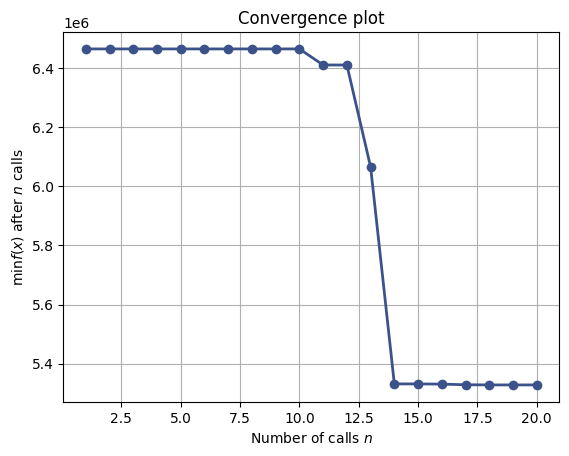

In [69]:
from skopt.plots import plot_convergence

_ = plot_convergence(hpo_pipe_scale_svr.optimizer_results_[0])
plt.show()

### Summary of Results

From the results we can see the r2 value of _________ and the mean absolute error of _________. The SVM model was the model that performed the worst out of the 5 different models. This may be due to the complexity of the data. SVMs might not perform well on highly complex datasets or datasets with intricate patterns. They work well when there is a clear margin of separation between classes. If the relationship between features and the target variable is not well-captured by hyperplanes, SVMs may struggle. SVM's are also computationally complex, so with the limited capabilities of my computer I had to have a low budget of 20. With a more capable computer, I would have been able to make a higher budget, and therefore get more accurate results. 

# 5th Model: Gradient Boosting Regressor

This final modal was giving us some trouble as it cause our machine to crash multiple times and when it didn't it get CPU temps above 95 degrees Celsius for extended periods of time which led to us stopping the process. That said, we were able to run a basic model without any HPO and get some decent results.

In [70]:
# Import necessary dependencies
from sklearn.ensemble import GradientBoostingRegressor

# instantiate the model with default hyperparameters
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
gbr_pred = gb.predict(X_test)

get_scores(gbr_pred)


Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       10049753383069.684   61839876045693.438   0.163     
R2                        0.837                -0.003               -304.537  
MAE                       2115066.904          6744592.742          0.314     
Ratio of mae over mean value of y: 0.125


### Let's take a look at residuals again

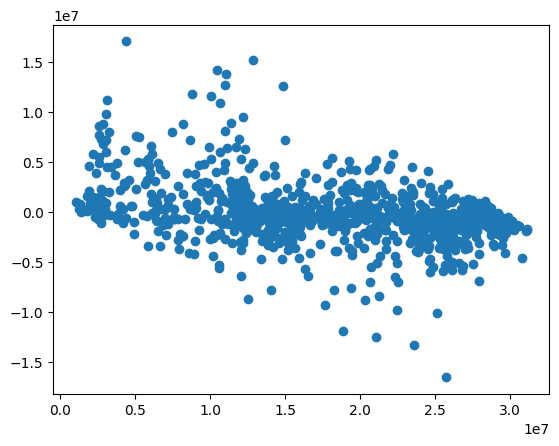

In [71]:
plt.scatter(y_test, gbr_pred - y_test)
plt.show()

## Hyperparameter tuning is what cause this to crash

We'll still include it, but don't recommend it be run on a machine without a top of the line cooler and cpu with multiple cores and threads. It's commented out for now so that it doesn't bog down our file.

In [72]:
# n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 10)]
# # learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
# max_depth = [int(x) for x in np.linspace(1, 100, num = 10)]
# # loss=['squared_error','absolute_error', 'huber', 'quantile']
# min_samples_split = [2, 5, 10, 15, 20]

# param_grid = {
#     'n_estimators': n_estimators,
#     'learning_rate': learning_rate,
#     'max_depth': max_depth,
#     'loss': loss,
#     'min_samples_split': min_samples_split
# }

# gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = param_grid, n_iter = 2, cv = 3, random_state=56, n_jobs = -1, scoring='neg_mean_absolute_error', verbose=4)

# gbr_random.fit(X_train, y_train)

# Final Model Selection

After looking at all of our models, ____ performed the best, with an MAE of _____, and an R2 score of ______.

In [73]:
import joblib

# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(better_knn, filename)


# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)
 


-11061126.259295499


c:\Users\Joao\Documents\GitHub\UC3M-MLBD\venv\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(
